<a href="https://www.kaggle.com/code/deeparker/sennet-unet-attention-unet-and-ensemble?scriptVersionId=194094983" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Kaggle Competition Notebook: SenNet + HOA - Hacking the Human Vasculature in 3D

<font size="4"> This notebook is a submission for the Kaggle competition '**SenNet + HOA - Hacking the Human Vasculature in 3D.**' The purpose of this notebook is to explore the given image dataset, as well as compare and ensemble popular computer vision algorithms (UNet and Attention UNET). </font>

## Introduction

<font size="4"> In this notebook, basic techniques will be explored for understanding and working with the competition's data. UNet and Attention UNET models will also be compared to see which may work best for this 'semantic segmentation' task. Semantic segmentation can be thought of as highlighting a picture based on different objects within the picture. </font>

<font size="4"> Information regarding the data and task can be found in the tournament overview. A link to this page is below. </font>

<font size="4"> [https://www.kaggle.com/competitions/blood-vessel-segmentation/overview](https://www.kaggle.com/competitions/blood-vessel-segmentation/overview) </font>



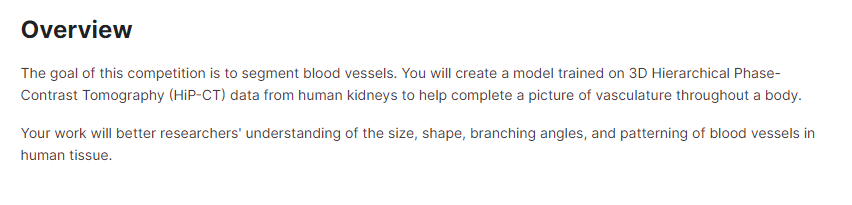

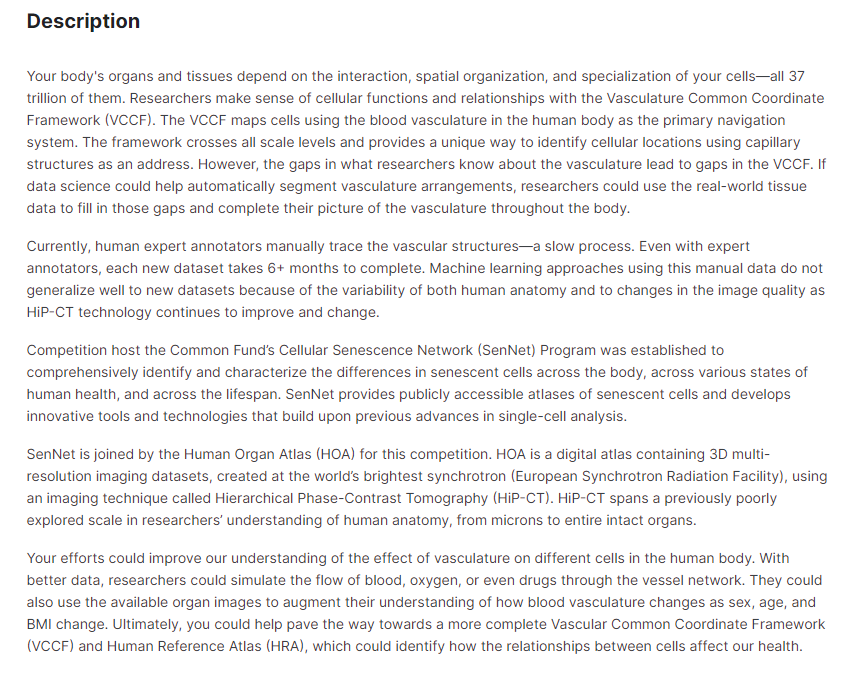

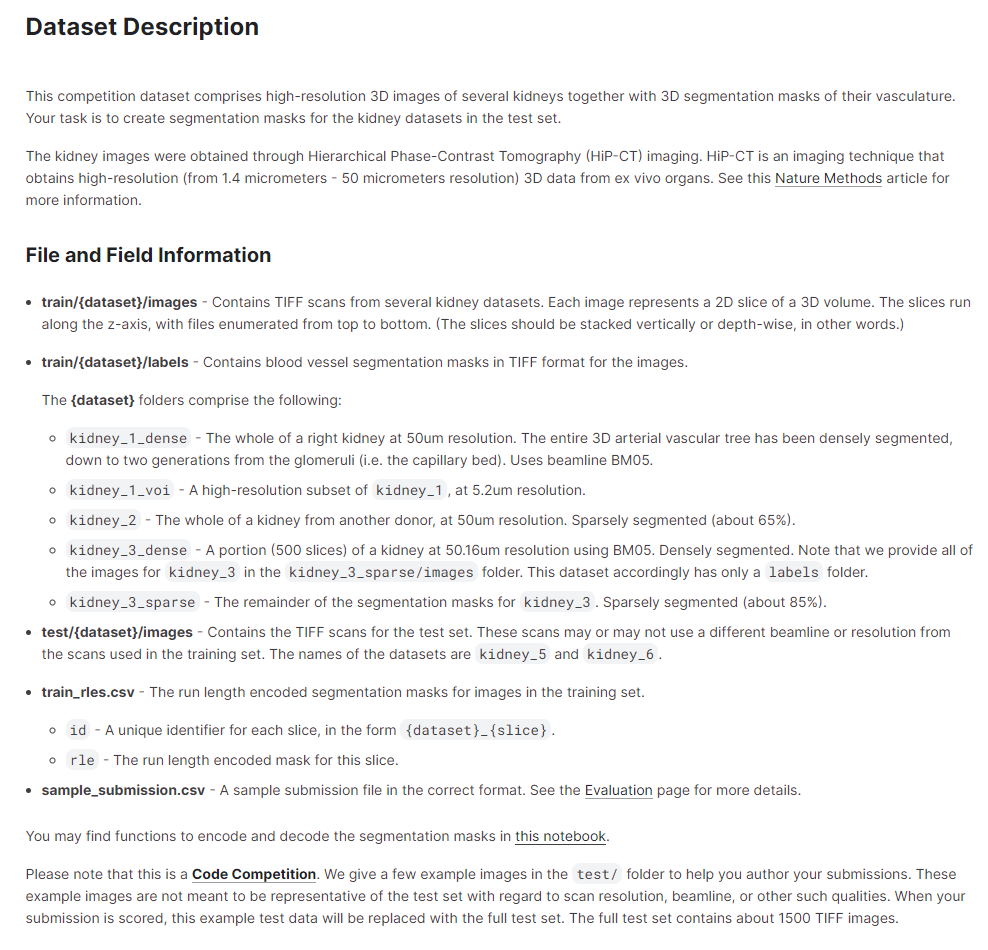

## Summary of Tournament Overview

<font size="4"> Imagine having a special camera capable of capturing 3D images inside a human kidney. However, the focus is not on observing the entire kidney; rather, it is on the intricate network of blood vessels within the kidney. Scientists aim to understand these blood vessels, including their visual characteristics, arrangement, and organization within the kidney. </font>

<font size="4"> Currently, scientists must manually trace these vessels, which is a time-consuming process. In this competition, Kaggle users are asked to build models capable of examining 3D kidney images and accurately outlining the blood vessels. This can be thought of as creating software that can accurately trace the blood vessels in a given kidney image. This is important because understanding these blood vessels can yield valuable insights. For example, scientists could simulate blood flow, oxygen transport, or medication distribution through these vessels. They could also observe how these blood vessels change in response to factors like age, size, or shape. </font>

<font size="4">To summarize, this competition asks Kaggle users to create models that can identify and outline blood vessels in 3D kidney images. This may assist scientists to gain deeper insights into the structure of blood vessels and their impact on our bodies. </font>

## Code

<font size="4"> To begin, import the required packages. </font>

In [ ]:
!pip install segmentation-models

In [ ]:
import os
import random
import time
import gc
import numpy as np
import tifffile
import cv2  
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (Input, Conv2D, UpSampling2D, Concatenate, Activation, Multiply, MaxPooling2D, Conv2DTranspose, concatenate)
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
import pandas as pd

os.environ["SM_FRAMEWORK"] = "tf.keras"  # Force segmentation_models to use tf.keras
from segmentation_models import Unet

# Disable cuDNN autotuning to avoid potential convolution algorithm mismatches and precision errors on GPU.
tf.config.optimizer.set_experimental_options({"cudnn_autotune": False})

from tensorflow.keras.mixed_precision import set_global_policy, Policy

# Set mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)


# Set random seed for reproducibility
np.random.seed(55)
tf.random.set_seed(55)

# Record the start time
start_time = time.time()

<font size="4"> The data is provided in a Kaggle notebook environment. The following code displays the unique paths available in the environment. </font>

In [ ]:
# Initialize an empty set to store unique folder paths
unique_folders = set()

# Specify the root directory
root_directory = '/kaggle/input'

# Iterate through all directories and subdirectories
for dirpath, dirnames, filenames in os.walk(root_directory):
    for dirname in dirnames:
        folder_path = os.path.join(dirpath, dirname)
        unique_folders.add(folder_path)

# Convert the set to a list and sort it
unique_folders_list = sorted(list(unique_folders))

# Print the sorted unique folder paths
for folder_path in unique_folders_list:
    print(folder_path)


<font size="4"> Viewing the available directories in the environment provides insight regarding the structure of the data that has been provided. Let's look at some files in the directories as well. Samples image and label file names can be viewed in the kidney_1_dense and kidney_2 directories.  </font>

In [ ]:
# Directories to explore
directories = [
    '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images',
    '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels',
    '/kaggle/input/blood-vessel-segmentation/train/kidney_2/images',
    '/kaggle/input/blood-vessel-segmentation/train/kidney_2/labels'
]

# Function to list first five files in a directory
def list_sample_files(directory, num_files=5):
    files = os.listdir(directory)
    return sorted(files)[:num_files]

# Iterate through the directories and list the first five files
for directory in directories:
    print(f"Files in {directory}:")
    files = list_sample_files(directory)
    for file in files:
        print(f"  {file}")
    print("\n")

<font size="4"> **Observing Folder Structure:**
  By examining the structure of the directories, a common pattern can be identified across the folders. Each kidney type is organized into subcategories, each containing two key directories:
  - <font size="4">An "image" directory: This directory contains the original kidney images.
  - <font size="4">A "label" directory: This directory contains the corresponding masks for those images.
  - <font size="4">The filenames in each directory match, which helps with pairing images and masks (e.g., "0000.tif," "0001.tif," etc.).
  - <font size="4">Note that kidney_3_dense only includes the label images (masks). For this reason, kidney_3_dense was not included in the training dataset.
  

<font size="4"> **Visualizing Kidney Data:**
  To gain insights into the data, the images and their associated masks can be visualized. Overlay representations for each distinct kidney are also displayed. To accomplish this, the following steps are performed through the code below:
  - <font size="4">Iterating through each subcategory directory.
  - <font size="4">Loading an image and its corresponding mask.
  - <font size="4">Generating an overlay of the mask onto the image.
  - <font size="4">Displaying the image, mask, and mask overlay side by side for enhanced comprehension.
  - <font size="4">Additionally, copies of the images with aesthetic enhancements, such as "equalized" images and color, have been added to improve the visual appeal of the representations.


In [ ]:
# Define the base directory path
base_path = "/kaggle/input/blood-vessel-segmentation/train/"

# Define a list of kidney types
kidney_types = ["kidney_1_dense", "kidney_1_voi", "kidney_2", "kidney_3_sparse"]

# Gradient function to create a radial gradient
def create_radial_gradient(size, center, max_radius, background_color, mask_color):
    gradient = np.zeros((size[0], size[1], 3), dtype=np.uint8)
    for y in range(size[0]):
        for x in range(size[1]):
            distance = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
            normalized_distance = distance / max_radius
            gradient[y, x, :] = [int((1 - normalized_distance) * mask_color + normalized_distance * background_color)] * 3
    return gradient

# Iterate through each kidney type
for selected_kidney_type in kidney_types:
    print(f"Displaying images for: {selected_kidney_type}")

    # Define the image and label directories for the selected kidney type
    image_directory = f"{selected_kidney_type}/images"
    label_directory = f"{selected_kidney_type}/labels"

    # Construct the full file path for the image directory
    image_path = os.path.join(base_path, image_directory)

    # Construct the full file path for the label directory
    label_path = os.path.join(base_path, label_directory)

    # Check if the file exists
    if os.path.exists(image_path) and os.path.exists(label_path):
        # List all files in the image directory
        image_files = os.listdir(image_path)

        # Randomly select an image file
        selected_image_file = random.choice(image_files)
        image_file_path = os.path.join(image_path, selected_image_file)

        # Load the original grayscale image
        image_gray = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)

        # Load the corresponding mask
        mask_file_path = os.path.join(label_path, selected_image_file)
        mask = cv2.imread(mask_file_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply histogram equalization to enhance contrast
        image_equalized = cv2.equalizeHist(image_gray)
        mask_equalized = cv2.equalizeHist(mask)

        # Overlay the mask on the original image
        original_overlay = cv2.addWeighted(cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR), 0.7, cv2.applyColorMap(mask, cv2.COLORMAP_JET), 0.3, 0)

        # Create a radial gradient for the background
        gradient_size = mask_equalized.shape
        gradient_center = (gradient_size[1] // 2, gradient_size[0] // 2)
        max_gradient_radius = min(gradient_center[0], gradient_center[1])
        radial_gradient = create_radial_gradient(gradient_size, gradient_center, max_gradient_radius, 220, 255)

        # Create a mask for the background
        background_mask = (mask_equalized == 0)

        # Apply the radial gradient to the background
        color_enhanced_mask = cv2.applyColorMap(mask_equalized, cv2.COLORMAP_JET)
        color_enhanced_mask[background_mask] = radial_gradient[background_mask]

        # Overlay the equalized mask on the equalized image
        equalized_overlay = cv2.addWeighted(cv2.cvtColor(image_equalized, cv2.COLOR_GRAY2BGR), 0.7, cv2.applyColorMap(mask_equalized, cv2.COLORMAP_JET), 0.3, 0)

        # Create the figure for displaying images
        plt.figure(figsize=(18, 8))

        # Displaying original set: image, mask, overlay
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB))
        plt.title(f'Original Image - {selected_kidney_type}')
        plt.axis('off')

        
        
        plt.subplot(2, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Original Mask - {selected_kidney_type}')
        plt.axis('off')

        plt.subplot(2, 3, 3)
        plt.imshow(cv2.cvtColor(original_overlay, cv2.COLOR_BGR2RGB))
        plt.title(f'Original Overlay - {selected_kidney_type}')
        plt.axis('off')

        # Displaying equalized set: image, mask, overlay
        plt.subplot(2, 3, 4)
        plt.imshow(cv2.cvtColor(image_equalized, cv2.COLOR_GRAY2RGB))
        plt.title(f'Color Enhanced Image - {selected_kidney_type}')
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(cv2.cvtColor(color_enhanced_mask, cv2.COLOR_BGR2RGB))
        plt.title(f'Color Enhanced Mask - {selected_kidney_type}')
        plt.axis('off')

        plt.subplot(2, 3, 6)
        plt.imshow(cv2.cvtColor(equalized_overlay, cv2.COLOR_BGR2RGB))
        plt.title(f'Color Enhanced Overlay - {selected_kidney_type}')
        plt.axis('off')

        plt.show()
    else:
        print(f"File not found: {image_path} or {label_path}")


gc.collect()

<font size='4'> The machine learning models require the images to be the same shape. The code below checks the image size dimensions for each kidney category.

In [ ]:
def get_image_dimensions(image_directory):
    # Define the path to the 'images' subdirectory
    images_path = os.path.join(image_directory, 'images')
    
    # Check if the 'images' subdirectory exists
    if not os.path.exists(images_path):
        print(f"'images' subdirectory does not exist in {image_directory}")
        return set()

    image_files = os.listdir(images_path)
    unique_shapes_and_channels = set()  # To collect unique image shapes and channels
    for image_file in image_files:
        if not image_file.lower().endswith(('.tif', '.tiff')):
            # Skip non-TIFF files
            continue

        full_image_path = os.path.join(images_path, image_file)
        try:
            image = cv2.imread(full_image_path, cv2.IMREAD_UNCHANGED)  # Use IMREAD_UNCHANGED to ensure TIFF files are read correctly
            if image is not None:
                if len(image.shape) == 3:
                    height, width, channels = image.shape
                else:
                    height, width = image.shape
                    channels = 1  # A single channel for grayscale images
                shape_and_channels = (height, width, channels)
                unique_shapes_and_channels.add(shape_and_channels)  # Collect unique shapes and channels
            else:
                print(f"Failed to load image: {image_file}")
        except Exception as e:
            print(f"Error while processing {image_file}: {str(e)}")
    return unique_shapes_and_channels

# Example usage
image_directories = [
    '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense',
    '/kaggle/input/blood-vessel-segmentation/train/kidney_2',
    '/kaggle/input/blood-vessel-segmentation/train/kidney_1_voi',
    '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse'
]

for image_directory in image_directories:
    print(f"Getting unique dimensions and channels for images in: {image_directory}")
    unique_shapes_and_channels = get_image_dimensions(image_directory)
    
    if unique_shapes_and_channels:
        print(f"Unique Image Shapes and Channels in {image_directory}:")
        for shape_and_channels in unique_shapes_and_channels:
            print(f"Shape and Channels: {shape_and_channels}")
    else:
        print(f"No valid TIFF image files found in {image_directory}")

gc.collect()

<font size="4"> **With the code above, the following information is able to be determined:**

- <font size="4"> **Images Shape Consistency:** For each directory, the images share the same shape. Each directory has unique image shapes, so the images will need to be resized to ensure that all images are the same size for training.

- <font size="4"> **Grayscale Images:** The images are grayscale (black and white), which is important as this will affect the architecture of the models.

- <font size="4"> **Basic Information for needed for computer vision models:**
  - <font size="4"> **Directories of Image and Label Files:** It is important that the image and label files are organized into directories suitable for the task. For image segmentation tasks, corresponding labels are needed to define the ground truth for the images. These labels specify which parts of the image correspond to different classes or objects.

  -  <font size="4">**Image Size:** This refers to the dimensions of the image (width and height in pixels.) The model needs to know the input size to correctly process the images.

  -  <font size="4">**Number of Channels:** It's important to determine whether the images are grayscale (single-channel) or color (typically three-channel RGB). This information is needed for setting up the input layer of the model.



# Preprocess Data

<font size="4"> **The code below does the following to preprocess the images for training:**

- <font size="4"> **Define Image Directories**: `image_paths` is a list that contains the paths to the directories where training images are stored. 

- <font size="4"> **Image Preprocessing Functions**: `preprocess_image` is a function that loads and preprocesses an image from a given file path. It reads a TIFF image, normalizes pixel values, adds a channel dimension (grayscale), and resizes the image to a fixed size (256x256 pixels). A similar function is used to preprocess the masks.

- <font size="4"> **Load and Preprocess Data**: The code loads and preprocesses both images and corresponding masks from the specified directories. It retrieves all image and mask file paths within the specified directories. Then, it applies the preprocessing functions to each image and mask, creating arrays of preprocessed images and masks.


In [ ]:
# Define the paths to the image directories
image_paths = [
    '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense',
    '/kaggle/input/blood-vessel-segmentation/train/kidney_2',
    '/kaggle/input/blood-vessel-segmentation/train/kidney_1_voi',
    '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse'
]

# Function to preprocess an image
def preprocess_image(data_folder):
    image = tifffile.imread(data_folder)
    if image.ndim == 2:  # Handle grayscale images
        image = image[..., np.newaxis]  # Add a channel dimension
    mean = np.mean(image)  # Normalize the pixel values
    std = np.std(image)
    image = (image - mean) / std
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.image.resize(image_tensor, [256, 256])
    return image_tensor

# Function to preprocess a mask
def preprocess_mask(path):
    mask = tifffile.imread(path)
    if mask.ndim == 2:  # Handle grayscale masks
        mask = mask[..., np.newaxis]  # Add a channel dimension
    mask_tensor = mask / 255.0  # Normalize the pixel values
    mask_tensor = tf.image.resize(mask_tensor, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return mask_tensor

# Load file paths for images and masks
image_files = []
label_files = []

# Get all files in the image and label folders for each path in image_paths
for image_path in image_paths:
    images_folder = os.path.join(image_path, 'images')
    labels_folder = os.path.join(image_path, 'labels')

    # List and sort the files
    images = sorted([os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.tif')])
    labels = sorted([os.path.join(labels_folder, f) for f in os.listdir(labels_folder) if f.endswith('.tif')])
    
    # Ensure the number of images and labels match
    if len(images) != len(labels):
        raise ValueError(f"Number of images and labels do not match in {image_path}")

    image_files.extend(images)
    label_files.extend(labels)

# Ensure that the number of images and masks match overall
if len(image_files) != len(label_files):
    raise ValueError("The number of images and masks do not match!")

# Split into train and validation sets with 20% for validation
image_files_train, image_files_val, label_files_train, label_files_val = train_test_split(image_files, label_files, test_size=0.2, random_state=42)




<font size="4">**Data Generator:** Instead of loading the entire dataset into memory at once (which may cause memory issues), a data generator is used to load smaller batches of images and masks during each training step. A batch size of four was chosen for this expirment. Larger batch sizes caused the models to throw a memory error. 

In [ ]:
# Define the batch size
batch_size = 4

# Define the data generator
def data_generator(image_files, label_files, batch_size):
    num_samples = len(image_files)
    
    # Generate batches of data
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_image_files = image_files[offset:offset + batch_size]
            batch_label_files = label_files[offset:offset + batch_size]
            
            # Preprocess images and masks dynamically
            batch_images = np.array([preprocess_image(f) for f in batch_image_files])
            batch_masks = np.array([preprocess_mask(f) for f in batch_label_files])
            
            yield batch_images, batch_masks



# Create datasets for training and validation using the generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(image_files_train, label_files_train, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(image_files_val, label_files_val, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32)
    )
)

# Prefetch the dataset to improve performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Optional: Garbage collection after dataset creation
gc.collect()

# Continue with model creation and training as before

- <font size="4"> **Subset Selection**: The dataset is into a 80% training dataset and 20% validation dataset.    

In [ ]:
# Total number of samples in your dataset
train_dataset_size = len(image_files_train)  # Total number of training samples
val_dataset_size = len(image_files_val)  # Total number of validation samples

# Calculate steps_per_epoch and validation_steps
train_steps_per_epoch = train_dataset_size // batch_size
validation_steps_per_epoch = val_dataset_size // batch_size

<font size="4">**Visualize Sample Images**: View a sample of images in the train_dataset and val_dataset to ensure the images and masks are aligned correctly.

In [ ]:
# Function to plot sample images and masks
def plot_samples(dataset, num_samples=1):
    # Create an iterator for the dataset
    iterator = iter(dataset)
    
    for _ in range(num_samples):
        # Get the next batch from the iterator
        images, masks = next(iterator)
        
        # Plot the first image and mask in the batch
        for i in range(batch_size):
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            
            # Image
            ax[0].imshow(tf.squeeze(images[i]), cmap='gray')
            ax[0].set_title("Image")
            
            # Mask
            ax[1].imshow(tf.squeeze(masks[i]), cmap='gray')
            ax[1].set_title("Mask")
            
            plt.show()

# Call the function to plot samples from the train dataset
plot_samples(train_dataset, num_samples=1)


<font size="4">The file names of images and masks can also be printed to confirm alignment.

In [ ]:
# Print first 5 image and mask file pairs to verify alignment
for img_file, mask_file in zip(image_files[:5], label_files[:5]):
    print(f"Image: {os.path.basename(img_file)} - Mask: {os.path.basename(mask_file)}")


- <font size="4"> **Imbalanced data check**: The masks are imbalanced, with 99% class 0 (background) and less than 1% class 1 (blood vessels). For this reason, a custom loss funtion will be defined which is better for training with imbalanced datasets (BCE Dice Loss, described below).

In [ ]:
# Function to calculate the class distribution (Background and Blood Vessels) with a threshold
def calculate_class_distribution(dataset, num_batches=None, threshold=0.5):
    class_0_count = 0
    class_1_count = 0
    total_batches = 0
    
    for batch_images, batch_masks in dataset:
        # Apply the threshold to binarize the masks
        binarized_masks = (batch_masks >= threshold).numpy().astype(int)
        
        # Flatten the masks to 1D array
        flattened_masks = binarized_masks.flatten()
        
        # Count class 0 (Background) and class 1 (Blood Vessels)
        class_0_count += np.sum(flattened_masks == 0)
        class_1_count += np.sum(flattened_masks == 1)
        
        total_batches += 1
        if num_batches and total_batches >= num_batches:
            break
    
    return class_0_count, class_1_count

# Call the function to calculate the class distribution on the training dataset
class_0_count, class_1_count = calculate_class_distribution(train_dataset, num_batches=100, threshold=0.5)

# Calculate the ratio of class 1 to class 0
if class_0_count == 0:
    print("No background pixels found in the dataset.")
else:
    class_ratio = class_1_count / class_0_count

    # Print the results
    print("Class 0 (Background) Count:", class_0_count)
    print("Class 1 (Blood Vessels) Count:", class_1_count)
    print("Class 1 to Class 0 Ratio:", class_ratio)


# Loss, Evaluation Metric and Parameters for Each Model

<font size="4">**Dice Coefficient (Custom Metric):** The `dice_coefficient` function computes the Dice coefficient, which is a similarity metric used to evaluate the overlap between two binary images (e.g., predicted and ground truth masks). It is a measure of how well the predicted mask aligns with the true mask.

<font size="4">**BCE Dice Loss (Custom Loss):** The `bce_dice_loss` function combines binary cross-entropy loss (`bce`) and the Dice coefficient defined below. This combined loss function is often used in image segmentation tasks to balance the trade-off between pixel-wise accuracy and segmentation quality.
    

In [ ]:
# Define the Dice Coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)
    total_loss = bce - K.log(dice)
    return total_loss



- <font size="4">**Early Stopping:** Stops training when validation loss stops improving, preventing overfitting. The patience parameter waits 5 epochs before stopping, and restore_best_weights=True ensures the model reverts to the best weights.

- <font size="4">**Learning Rate Schedule:** Gradually decreases the learning rate each epoch. The rate starts at 0.001 and decays each epoch by multiplying by 0.96, helping the model converge smoothly.
    
- <font size="4">**ReduceLROnPlateau:** Lowers the learning rate when validation loss plateaus to help the model continue improving. If no improvement is seen for 3 epochs, the learning rate is reduced by a factor of 0.2, with a minimum limit of 0.00001.

In [ ]:
# Early stopping callback to monitor validation Dice coefficient
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation Dice coefficient
    patience=5,                      # Number of epochs with no improvement after which training will be stopped
    mode='min',                      # Mode should be 'min' as we want to minimize validation loss
    min_delta=0.01,                  # Minimum change to qualify as an improvement
    restore_best_weights=True        # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define the learning rate schedule as a callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch, lr: 0.001 * 0.96 ** (epoch / 100),
    verbose=1
)

# Define the ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=3, 
    min_lr=0.00001
)



# Pre-Trained U-Net Model
<font size="4"> The first model in this expiriment is a pre-trained U-Net. The code below does the following:

<font size="4">**Defines a pre-trained U-Net model for image segmentation:** The U-Net architecture is adapted with a ResNet50 backbone that is pre-trained on ImageNet. It supports binary segmentation tasks and has been modified to work with grayscale images by converting the input to RGB format. The model is compiled with the custom BCE Dice loss function and the Dice coefficient metric defined above.

<font size="4">**Adjusting for grayscale input:** The model is originally designed for RGB images, but is adjusted to accept grayscale images by replicating the single channel into three channels to mimic RGB.

<font size="4">**Fitting the model:** The model is trained for 25 epochs with early stopping and learning rate adjustments to minimize validation loss. A checkpoint callback is implemented to save the best model during training.

In [ ]:
# Function to create a pre-trained U-Net model
def create_pretrained_unet(input_shape):
    # Load a pre-trained ResNet50 backbone from ImageNet and adapt it for U-Net
    unet_model = Unet(backbone_name='resnet50', encoder_weights='imagenet', input_shape=input_shape, classes=1, activation='sigmoid')
    return unet_model

# Function to adjust for grayscale input
def adjust_input_for_grayscale(model, input_shape):
    # Replace the input layer to accept grayscale images
    input_layer = layers.Input(shape=input_shape)
    grayscale_to_rgb = layers.Concatenate()([input_layer, input_layer, input_layer])  # Convert grayscale to RGB
    output = model(grayscale_to_rgb)
    grayscale_model = Model(inputs=input_layer, outputs=output)
    
    return grayscale_model

# Adjusted for grayscale images
input_shape = (256, 256, 1)
unet_model = create_pretrained_unet((256, 256, 3))
unet_model = adjust_input_for_grayscale(unet_model, input_shape)

# Compile the model
unet_model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient])


In [ ]:
# Define the ModelCheckpoint callback
checkpoint_unet = ModelCheckpoint(
    'best_model_unet.keras',  # File path where the model will be saved
    monitor='val_loss',  # Metric to monitor
    mode='min',  # We want to minimize validation loss
    save_best_only=True,  # Only save the best model
    verbose=1
)

# Train the enhanced ResNet model
epochs = 25

# Train the U-Net model and store the history
history_unet = unet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=validation_steps_per_epoch,
    callbacks=[early_stopping, reduce_lr, lr_schedule, checkpoint_unet]
)



In [ ]:
# Extract the best epoch results for U-Net
best_epoch_unet = history_unet.history['val_loss'].index(min(history_unet.history['val_loss']))

# Store the results
final_results_unet = {
    "Best Epoch": best_epoch_unet + 1,  # Convert to 1-based indexing
    "Training Loss": history_unet.history['loss'][best_epoch_unet],
    "Validation Loss": history_unet.history['val_loss'][best_epoch_unet],
    "Training Dice Coefficient": history_unet.history['dice_coefficient'][best_epoch_unet],
    "Validation Dice Coefficient": history_unet.history['val_dice_coefficient'][best_epoch_unet]
}

# Print the results
print(f"Best Epoch (U-Net): {final_results_unet['Best Epoch']}")
print(f"Training Loss (Best Epoch): {final_results_unet['Training Loss']}")
print(f"Validation Loss (Best Epoch): {final_results_unet['Validation Loss']}")
print(f"Training Dice Coefficient (Best Epoch): {final_results_unet['Training Dice Coefficient']}")
print(f"Validation Dice Coefficient (Best Epoch): {final_results_unet['Validation Dice Coefficient']}")


<font size="4">The model performed well, with a final validation loss of 0.083 and Dice Coefficeint of 0.923. A sample of the predictions can be visualized to ensure the model is predicting the masks as expected. 

In [ ]:
# Function to visualize original image, ground truth mask, and predicted mask
def visualize_predictions(model, val_dataset, num_samples=3):
    # Get a batch of data from the validation dataset
    for images, masks in val_dataset.take(1):
        # Predict using the trained model
        predictions = model.predict(images)
        
        # Loop through the first few samples
        for i in range(num_samples):
            # Extract the image, true mask, and predicted mask
            image = images[i].numpy().squeeze()  # Remove extra dimensions if necessary
            true_mask = masks[i].numpy().squeeze()
            predicted_mask = predictions[i].squeeze()

            # Create a subplot with 3 columns: Image, True Mask, and Predicted Mask
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            
            # Original image
            ax[0].imshow(image, cmap='gray')
            ax[0].set_title("Original Image")
            ax[0].axis('off')
            
            # Ground truth mask
            ax[1].imshow(true_mask, cmap='gray')
            ax[1].set_title("True Mask")
            ax[1].axis('off')
            
            # Predicted mask (use a threshold to binarize the prediction)
            ax[2].imshow(predicted_mask > 0.5, cmap='gray')  # Apply a threshold of 0.5
            ax[2].set_title("Predicted Mask")
            ax[2].axis('off')

            plt.show()



In [ ]:
# Call the visualization function
visualize_predictions(unet_model, val_dataset, num_samples=4)

In [ ]:
gc.collect()
K.clear_session()

<font size="4">The predicted masks appear to align correctly with the true mask images.

# Comparing U-Net to Attention U-Net
<font size="4">The Attention U-Net is a newer algorithm. It enhances the U-Net architecture by introducing attention mechanisms, allowing the model to focus on the most relevant features during segmentation. This refinement is particularly effective for complex or noisy images. The architecture uses an encoder-decoder structure with attention blocks between corresponding layers in the contracting and expansive paths to guide the model’s focus.

<font size="4">**Differences from U-Net:**
The key difference between U-Net and Attention U-Net is the use of attention blocks. While the standard U-Net employs simple skip connections to transfer feature maps from the contracting path to the expansive path, the Attention U-Net selectively emphasizes important features through attention mechanisms, improving segmentation performance on complex tasks.

<font size="4">**Diverse Modeling Approaches:**
Both U-Net and Attention U-Net offer different approaches to segmentation tasks. U-Net is a robust general-purpose segmentation model, while Attention U-Net is more specialized, applying attention to enhance performance on complex or noisy datasets. Comparing these models allows for an evaluation of how different architectural strategies perform on the same task. The unique architechures could also be combined for ensemble predictions. 

In [ ]:
# Function to create Attention Gate
def attention_gate(x, g, inter_shape):
    # Upsample g to match the shape of x
    g = UpSampling2D(size=(x.shape[1] // g.shape[1], x.shape[2] // g.shape[2]))(g)
    
    theta_x = Conv2D(inter_shape, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(inter_shape, (1, 1), strides=(1, 1), padding='same')(g)
    
    add_xg = layers.Add()([theta_x, phi_g])
    relu_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(relu_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    
    attention = Multiply()([x, sigmoid_xg])
    return attention

# Function to create a pre-trained Attention U-Net with a complete decoder
def create_pretrained_attention_unet(input_shape):
    # Load a pre-trained ResNet50 backbone
    backbone = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    
    # Encoder output from the ResNet50 backbone
    conv_output = backbone.output

    # Decoder: progressively upsample and add attention gates
    up1 = UpSampling2D(size=(2, 2))(conv_output)
    att1 = attention_gate(backbone.get_layer('conv4_block6_out').output, up1, inter_shape=256)
    concat1 = Concatenate()([att1, up1])
    
    up2 = UpSampling2D(size=(2, 2))(concat1)
    att2 = attention_gate(backbone.get_layer('conv3_block4_out').output, up2, inter_shape=128)
    concat2 = Concatenate()([att2, up2])

    up3 = UpSampling2D(size=(2, 2))(concat2)
    att3 = attention_gate(backbone.get_layer('conv2_block3_out').output, up3, inter_shape=64)
    concat3 = Concatenate()([att3, up3])

    up4 = UpSampling2D(size=(2, 2))(concat3)
    att4 = attention_gate(backbone.get_layer('conv1_relu').output, up4, inter_shape=32)
    concat4 = Concatenate()([att4, up4])

    # Add one more upsampling to reach the desired output size of 256x256
    up5 = UpSampling2D(size=(2, 2))(concat4)
    
    # Final convolution layer to reduce channels to 1 and apply sigmoid activation
    output = Conv2D(1, (1, 1), activation='sigmoid')(up5)

    # Create the complete model
    model = Model(inputs=backbone.input, outputs=output)
    return model

# Adjust for grayscale images
input_shape = (256, 256, 1)
attention_unet_model = create_pretrained_attention_unet((256, 256, 3))
attention_unet_model = adjust_input_for_grayscale(attention_unet_model, input_shape)

# Compile the model
attention_unet_model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coefficient])


In [ ]:
# Re-initialize early stopping and learning rates to reset the callback results
early_stopping_att_unet = EarlyStopping(
    monitor='val_loss',  # Monitor the validation Dice coefficient
    patience=5,                      # Number of epochs with no improvement after which training will be stopped
    mode='min',                      # Mode should be 'min' as we want to minimize validation loss
    min_delta=0.01,                  # Minimum change to qualify as an improvement
    restore_best_weights=True        # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define the learning rate schedule as a callback
lr_schedule_att_unet = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch, lr: 0.001 * 0.96 ** (epoch / 100),
    verbose=1
)

# Define the ReduceLROnPlateau callback
reduce_lr_att_unet = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=3, 
    min_lr=0.00001
)



In [ ]:
# Define the ModelCheckpoint callback
checkpoint_att_unet = ModelCheckpoint(
    'best_model_att_unet.keras',  # File path where the model will be saved
    monitor='val_loss',  # Metric to monitor
    mode='min',  # We want to minimize validation loss
    save_best_only=True,  # Only save the best model
    verbose=1
)

# Fit the model
history_att_unet = attention_unet_model.fit(
train_dataset,
validation_data=val_dataset,
epochs=epochs,
steps_per_epoch=train_steps_per_epoch,
validation_steps=validation_steps_per_epoch,
callbacks=[early_stopping_att_unet, reduce_lr_att_unet, lr_schedule_att_unet, checkpoint_att_unet]
)

In [ ]:
# Extract the best epoch results for Attention U-Net
best_epoch_attention_unet = history_att_unet.history['val_loss'].index(min(history_att_unet.history['val_loss']))

# Store the results for Attention U-Net
final_results_attention_unet = {
    "Best Epoch": best_epoch_attention_unet + 1,  # Convert to 1-based indexing
    "Training Loss": history_att_unet.history['loss'][best_epoch_attention_unet],
    "Validation Loss": history_att_unet.history['val_loss'][best_epoch_attention_unet],
    "Training Dice Coefficient": history_att_unet.history['dice_coefficient'][best_epoch_attention_unet],
    "Validation Dice Coefficient": history_att_unet.history['val_dice_coefficient'][best_epoch_attention_unet]
}

# Print the results for Attention U-Net
print(f"Best Epoch (Attention U-Net): {final_results_attention_unet['Best Epoch']}")
print(f"Training Loss (Best Epoch): {final_results_attention_unet['Training Loss']}")
print(f"Validation Loss (Best Epoch): {final_results_attention_unet['Validation Loss']}")
print(f"Training Dice Coefficient (Best Epoch): {final_results_attention_unet['Training Dice Coefficient']}")
print(f"Validation Dice Coefficient (Best Epoch): {final_results_attention_unet['Validation Dice Coefficient']}")


<font size="4">The attention Unet performed significantly worse than the traditional Unet well with 0.283 validation loss and 0.77 Dice coefficient. Sample predictions for this model can be visualized as well.

In [ ]:
# Call the visualization function
visualize_predictions(attention_unet_model, val_dataset, num_samples=4)

In [ ]:
gc.collect()
K.clear_session()

# Results
<font size="4">A dataframe can be created to compare the final results of each model.

In [ ]:
final_results_ensemble = {
    "Training Loss": ((history_unet.history['loss'][best_epoch_unet] + history_att_unet.history['loss'][best_epoch_attention_unet]) / 2),
    "Validation Loss": ((history_unet.history['val_loss'][best_epoch_unet] + history_att_unet.history['val_loss'][best_epoch_attention_unet]) / 2),
    "Training Dice Coefficient": ((history_unet.history['dice_coefficient'][best_epoch_unet] + history_att_unet.history['dice_coefficient'][best_epoch_attention_unet]) / 2),
    "Validation Dice Coefficient": ((history_unet.history['val_dice_coefficient'][best_epoch_unet] + history_att_unet.history['val_dice_coefficient'][best_epoch_attention_unet]) / 2)
}


In [ ]:
# Create the DataFrame using the results dictionaries
results_df = pd.DataFrame({
    'Training Loss': [
        final_results_unet['Training Loss'], 
        final_results_attention_unet['Training Loss'], 
        final_results_ensemble['Training Loss']
    ],
    'Validation Loss': [
        final_results_unet['Validation Loss'], 
        final_results_attention_unet['Validation Loss'], 
        final_results_ensemble['Validation Loss']
    ],
    'Training Dice Coefficient': [
        final_results_unet['Training Dice Coefficient'], 
        final_results_attention_unet['Training Dice Coefficient'], 
        final_results_ensemble['Training Dice Coefficient']
    ],
    'Validation Dice Coefficient': [
        final_results_unet['Validation Dice Coefficient'], 
        final_results_attention_unet['Validation Dice Coefficient'], 
        final_results_ensemble['Validation Dice Coefficient']
    ]
}, index=['unet', 'attention_unet', 'ensemble'])

# Display the DataFrame
results_df


<font size="4">The traditional Unet performed best with a validation loss of 0.09 and validation Dice coefficient of 0.93. The final attention Unet model resulted in a validation loss of 0.283 and validation Dice coefficient of 0.776. The ensemble resulted in a validation loss of 0.189 and validation dice coefficient of 0.852.
Due to the significant gap in performance, for this task it would be best to use the traditional Unet model alone without ensembling the two models. Perhaps exploring different architectures or ensembling three or more models could be explored further.


# Issue with test predictions

<font size="4">Although the model performs well on the validation set, predictions of the test set yield blank masks (ie all RLE values of '1 0'). Upon review, it appears the test data set is comprised of a single image that is duplicated for the entire set. The image contains an empty mask, which is why the test predicions contain only predictions of '1 0.' This appears to cause an issue with submission. The images in the test dataset can predicted and visualized with the code below. Also the submission dataframe with RLE encoding is created.

In [ ]:
# Function for Run-Length Encoding (RLE)
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Function to preprocess test images
def preprocess_test_image(image_path):
    image = tifffile.imread(image_path)
    if image.ndim == 2:
        image = image[..., np.newaxis]  # Add a channel dimension for grayscale
    image = (image - np.mean(image)) / np.std(image)  # Normalize
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.image.resize(image_tensor, [256, 256])  # Resize to match training size
    return image_tensor

# Function to predict masks for test images
def predict_test_images(test_image_paths, models):
    predictions = []
    for image_path in test_image_paths:
        image = preprocess_test_image(image_path)
        image = tf.expand_dims(image, axis=0)  # Add batch dimension
        ensemble_pred = np.mean([model.predict(image) for model in models], axis=0)  # Ensemble prediction
        prediction = (ensemble_pred > 0.5).astype(np.uint8).squeeze()  # Threshold and squeeze to remove extra dimensions
        predictions.append(prediction)
    return predictions

# Load test image paths
test_image_paths = []
test_image_ids = []

test_dir = '/kaggle/input/blood-vessel-segmentation/test/'
for dataset in os.listdir(test_dir):
    dataset_dir = os.path.join(test_dir, dataset, 'images')
    for image_file in sorted(os.listdir(dataset_dir)):
        test_image_paths.append(os.path.join(dataset_dir, image_file))
        test_image_ids.append(f"{dataset}_{image_file.split('.')[0]}")

# Get predictions for test images
models = [unet_model, attention_unet_model]  # Your trained ensemble models
predictions = predict_test_images(test_image_paths, models)

# Prepare submission data
submission_data = []
for image_id, mask in zip(test_image_ids, predictions):
    if np.sum(mask) == 0:  # If the mask is empty, submit "1 0"
        rle = '1 0'
    else:
        rle = rle_encode(mask)
    submission_data.append([image_id, rle])

# Create submission dataframe
submission_df = pd.DataFrame(submission_data, columns=['id', 'rle'])

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


In [ ]:
submission_df

<font size="4"> The original test images can also be vizualized by giving the discrete path to each file. This does appear to confirm that the test image data set is comprised of duplicates of one single image that yields an empty prediction ('1 0'). It is unfortunate that this issue exists in the environment with the test data set. Fortunatley, the models perform well on the validation images and work as expected.

In [ ]:
# Visualize Original Test Images
def visualize_original_images(image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(12, 6))
    
    for i, image_path in enumerate(image_paths):
        image = tifffile.imread(image_path)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Original: {os.path.basename(image_path)}')
        axes[i].axis('off')
    
    plt.show()

# Example usage with the same paths displayed
example_paths = [
    '/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/0001.tif',
    '/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/0002.tif',
    '/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/0000.tif',
    '/kaggle/input/blood-vessel-segmentation/test/kidney_6/images/0001.tif'
]

visualize_original_images(example_paths)


# Conclusion
<font size="4"> The traditional Unet algorithm perormed best for this task. Ensembling would not be beneficial as the results of the traditional Unet alone yielded the best performance. Unfortunatley, the duplicate images in the test dataset cannot be used for evaluation.
    
<font size="4">**Key Takeaways**:

- <font size="4">**Understanding Data Structure:**
  <font size="4">Understanding the structure and shape of the images, directories, and types of image files was an important factor in this experiment. Often, similar models did not perform well depending on how the images were preprocessed. I experimented with different computer vision libraries to create the datasets. I tested memory-efficient approaches, such as image generators (both built-in generators and custom ones). The keras dataloader worked best for this experiment. Perhaps further experimentation can be done to more efficiently preprocess the images to train on larger datasets. It is particularly important to note that, due to memory constraints, the models in this experiment were run with batch sizes of 4. These may be considered a smaller batch size and causes longer training times.
    

- <font size="4"> **Data Augmentation:** 
  <font size="4"> Data augmentation was not used in this experiment. Attempts to incorporate data augmentation resulted in poor model performance. Perhaps additional expirmentation can be explored to implement image augmentation.
      
      
- <font size="4"> **Importance of Choosing an Appropriate Loss Function:**
<font size="4"> When working with datasets that have a severe class imbalance, such as a high proportion of background pixels compared to blood vessel pixels, selecting the right loss function is an important factor. In this case, BCE Dice loss was used. This loss function is well-suited for binary segmentation tasks with a class imbalance. </font>
      
 

## Feedback and Comments
<font size="4">Thank you to anyone who has taken the time to review this notebook. Comments, feedback, corrections etc. would be greatly appreciated. Thank you also to the Kaggle community and participants in this competition who have shared their ideas. The ability to review the submissions of others greatly helped with the completion of this notebook. ChatGPT was also used to assist with this notebook.

In [ ]:
# Record the end time
end_time = time.time()

# Calculate the elapsed time in seconds
elapsed_time_seconds = end_time - start_time

# Calculate hours, minutes, and seconds
hours, remainder = divmod(int(elapsed_time_seconds), 3600)
minutes, seconds = divmod(remainder, 60)

# Print the elapsed time in hours, minutes, and seconds
print(f"Notebook run time: {hours} hours, {minutes} minutes, {seconds} seconds")
